In [2]:
#%matplotlib inline
import os
import numpy as np
from PIL import Image
import urllib, cStringIO
import matplotlib as mp
from matplotlib import pyplot,pylab
plt = pyplot
import scipy
import PIL
import base64
import sys
from matplotlib.pyplot import imshow
from __future__ import division

import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
import string
import pandas as pd
from scipy import stats


%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs

import json
import pymongo as pm

from svgpathtools import parse_path, wsvg, svg2paths


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

## purpose

#### upload sketches to S3 [maybe do this later]
#### build stimulus dictionary and write to database

## upload sketches to S3 [todo later]

## build stimulus dictionary

In [3]:
## read in experimental metadata file (CSV)
path_to_metadata = 'sketchpad_basic_allcats.csv'
_meta = pd.read_csv(path_to_metadata)   ### raw meta with all categories


In [4]:
# print first few rows of meta
_meta.head()

,gameID,trialNum,condition,target,drawDuration,outcome,response,numStrokes,Distractor1,Distractor2,Distractor3,pose,iteration,svg,viewerRT,mean_intensity,category
0,7004-6ff0964c-ff95-40f9-8696-d6a8931c94d5,1,further,knob,18.389,True,knob,7,crow,redsport,basset,35,pilot2,"[u'M69,167c0,27.13435 5,54.84972 5,81c0,1.8150...",6.656,0.0347,chair
1,7004-6ff0964c-ff95-40f9-8696-d6a8931c94d5,2,further,redsport,2.820,True,redsport,3,crow,knob,basset,35,pilot2,"[u'M51,224c0,-65.25556 75.24654,-35.24654 83,-...",5.607,0.0320,car
2,7004-6ff0964c-ff95-40f9-8696-d6a8931c94d5,3,closer,bluesport,22.093,False,beetle,5,beetle,hatchback,bluesedan,35,pilot2,"[u'M34,212c5.3353,-10.6706 6.56215,-22.81075 9...",6.695,0.0466,car
3,7004-6ff0964c-ff95-40f9-8696-d6a8931c94d5,4,closer,chihuahua,24.122,True,chihuahua,14,weimaraner,doberman,pug,35,pilot2,"[u'M99,157c-26.4479,17.63193 -2.9121,54.60807 ...",3.133,0.0371,dog
4,7004-6ff0964c-ff95-40f9-8696-d6a8931c94d5,5,closer,pug,34.260,False,chihuahua,12,weimaraner,doberman,chihuahua,35,pilot2,"[u'M69,172c0,4.72338 -5.37528,22.62472 -2,26c9...",5.739,0.0381,dog


In [5]:
## TODO: what we actually want Make sure that the data we're excluding from annotation 
## really the come from the trials where we had the shift-key artifact. 
## Right now, we are excluding sketches with numStrokes > mu + 3*sd, which is an imperfect proxy for that.
#mu = np.mean(_meta['numStrokes'])
#sd = np.std(_meta['numStrokes'])
#thresh = mu + 3*sd
#_meta = _meta[_meta['numStrokes']<thresh]
#_meta.reset_index(inplace=True) ## reset index on meta_chairs

## subset by chairs
meta_chairs = _meta[_meta['category']=='chair'] ### subsetted meta with just chairs

## sub-select good 4 chairs
## inlay>waiting>straight>leather
chairs4_list = ['inlay','waiting','straight','leather']
meta_chairs4 = meta_chairs[meta_chairs['target'].isin(chairs4_list)]
meta_chairs4.reset_index(inplace=True)

## assign which meta we will actually upload to mongo in this session
category_flag = 'allcats' ## options: ['allcats','chairs','chairs4']

if category_flag == 'chairs':
    meta = meta_chairs
elif category_flag == 'chairs4':
    meta = meta_chairs4
elif category_flag == 'allcats':
    meta = _meta

In [6]:
## add parts list
parts =[]
for i in range(meta.shape[0]-1):
    if meta.category[i]=="chair":
        parts.append(["backrest,armrest,seat,leg"])        
    if meta.category[i]=="dog":
        parts.append(["eye,mouth,ear,head,neck,body,leg,paw,tail"])
    if meta.category[i] == "bird":
        parts.append(["eye,beak,head,body,wing,leg,feet,tail"])
    if meta.category[i] == "car":
        parts.append(["bumper,headlight,hood,windshield,window,body,door,trunk,wheel"])
meta = meta.assign(parts=pd.Series(parts))

In [7]:
## add iteration name information
_iterationName = 'sketchpad_basic_{}'.format(category_flag)
iterationName = [_iterationName]*len(meta)
meta = meta.assign(iterationName=pd.Series(iterationName))

In [8]:
print meta.columns

Index([u'gameID', u'trialNum', u'condition', u'target', u'drawDuration',
       u'outcome', u'response', u'numStrokes', u'Distractor1', u'Distractor2',
       u'Distractor3', u'pose', u'iteration', u'svg', u'viewerRT',
       u'mean_intensity', u'category', u'parts', u'iterationName'],
      dtype='object')


In [9]:
## svg string formatting
svg = []
for i,d in meta.iterrows():    
    splitted = d['svg'].split("'") ## parse string to re-split up into strokes
    svgString = [i for i in splitted if i[0]=='M'] ## check to make sure it is a real start of a spline
    svg.append(svgString)
meta = meta.assign(svg=pd.Series(svg)) 

In [10]:
## add numSplines to the meta data
numSplines = []
for sk_ind, sketch in enumerate(meta.svg.values):
    num_splines = 0
    for stroke_ind,stroke in enumerate(sketch):
        parsed = parse_path(stroke)
        num_splines += len(parsed)
    numSplines.append(num_splines)
meta = meta.assign(numSplines=pd.Series(numSplines))     

In [11]:
## add empty games list
games = [[] for i in np.arange(len(meta))]
meta = meta.assign(games=pd.Series(games))

In [12]:
print 'The mean number of splines per sketch is {}.'.format(meta['numSplines'].mean())

The mean number of splines per sketch is 39.6307123656.


In [13]:
## filter so we can cover all the sketches multiple times with a budget of around $500 
budget_cap = 500
base_pay = 0.35
spline_bonus = 0.002
completion_bonus = 0.02 
num_trials_per_hit = 10
num_splines_per_sketch = meta['numSplines'].mean()
expected_bonus = 0.02*num_trials_per_hit + 0.002*num_trials_per_hit*num_splines_per_sketch
amt_commission = 1.2
mean_cost_single_session = (base_pay + expected_bonus) * amt_commission
print 'We expect to pay out approx. ${:.2f} per session, including commission.'.format(mean_cost_single_session)
num_sessions = int(np.floor(budget_cap/mean_cost_single_session))
print 'We have enough money to run approx. {} sessions.'.format(num_sessions)
num_total_annotation_trials_in_budget = num_sessions * 10
num_times_per_sketch = 3
num_unique_sketches_annotatable = num_total_annotation_trials_in_budget/3
print 'We can afford to annotate approx. {} sketches {} times each.'.format(int(num_unique_sketches_annotatable), num_times_per_sketch)
num_sketches_per_game = 32
print "That means we can fully annotate approx. {} games' worth of sketches.".format(int(num_unique_sketches_annotatable/num_sketches_per_game))

We expect to pay out approx. $1.61 per session, including commission.
We have enough money to run approx. 310 sessions.
We can afford to annotate approx. 1033 sketches 3 times each.
That means we can fully annotate approx. 32 games' worth of sketches.


In [14]:
### maybe filter on games that had both high accuracy and big context effect (big diff in num strokes between close & far)
## get list of games sorted by accuracy
games_sorted_by_accuracy = meta.groupby(['gameID'])['outcome'].mean().reset_index().sort_values('outcome',ascending=False).gameID.values

## get list of games sorted by how many more strokes were used in close condition than far condition
# reshape dataframe that computes mean strokes for each condition for each game
mean_strokes_in_condition_per_game = meta.groupby(['gameID','condition'])['numStrokes'].mean().reset_index().sort_values('gameID',ascending=True)
mscg = mean_strokes_in_condition_per_game
# pivots table to make two columns for each condition
msg = mscg.pivot(index='gameID', columns='condition')['numStrokes'].reset_index()
# assigns new column with close vs. far diff, then sorts
msg['diff'] = msg.apply(lambda x: x['closer'] - x['further'],axis=1)
msg = msg.sort_values('diff',ascending=False).reset_index()
# get list of games sorted by difference in num strokes used in each condition
games_sorted_by_contextDiff = msg['gameID'].values

In [15]:
## compute a composite rank measure that integrates accuracy rank and contextDiff Rank
game_list = games_sorted_by_accuracy
acc_rank = []
con_rank = []
composite_rank = []
for this_game in game_list:
    gsa = games_sorted_by_accuracy
    gsc = games_sorted_by_contextDiff

    a = np.where(gsa==this_game)[0][0] # rank of this game in accuracy-ranked list
    b = np.where(gsc==this_game)[0][0] # rank of this game in contextDiff-ranked list
    c = a + b # composite rank score
    acc_rank.append(a)
    con_rank.append(b)
    composite_rank.append(c)

## an optional visualization interlude to see what the relationship is between
## accuracy and contextDiff is across games        
reallyRun = 0
if reallyRun:
    ## plot acc_rank against con_rank -- are they related at all?
    plt.scatter(acc_rank,con_rank)
    stats.pearsonr(acc_rank,con_rank)
    plt.xlabel('rank by accuracy')
    plt.ylabel('rank by context diff')
    thresh = 70
    plt.plot([0,thresh],[thresh,0],'k:')
    plt.xlim(0,93)
    plt.ylim(0,93)
    plt.show()  
    print 'There were {} games that had composite rank score < {}.'.format(len([i for i in composite_rank if i<thresh]),thresh)

In [16]:
##Choose a filter mode: accuracy or composite
filter_mode = 'accuracy'

if filter_mode == 'composite':
##extract the list of "good games" with lowest composite score
    good_games = [i for (i,j) in zip(game_list,composite_rank) if j<70]
elif filter_mode == 'accuracy':
##extract the list of top 40 "good games" with lowest accuracy rank   
    good_games = [i for (i,j) in zip(game_list, acc_rank) if j<40]

## now define a meta2 dataframe that ONLY contains data from the "good games"
meta2 = meta[meta['gameID'].isin(good_games)]

In [17]:
## toggle whether we want to use the full dataset or the subset
subsetted = True
if subsetted:
    meta = meta2

In [18]:
## how many games worth of data do we have?
print '{} unique games worth of data.'.format(len(np.unique(meta.gameID.values)))
print '{} unique sketches.'.format(len(meta))

40 unique games worth of data.
1280 unique sketches.


### interlude to examine detailed statistics on constituent splines

In [19]:
## svg is a list of sketches
## each entry contains a list of strokes
## first let's convert into absolute coordinates
## then let's convert these into a list of splines that are "long enough"

In [20]:
def convert_relative_spline_to_absolute(parsed):
    svg_abs = ''
    for i,p in enumerate(parsed):
        if len(p)==4: ## cubic bezier
            svg_abs += ' M '
            svg_abs += '{},{}'.format(str(p.start.real),str(p.start.imag))
            svg_abs += ' C'
            svg_abs += ' {},{}'.format(str(p.control1.real),str(p.control1.imag))
            svg_abs += ' {},{}'.format(str(p.control2.real),str(p.control2.imag))
            svg_abs += ' {},{}'.format(str(p.end.real),str(p.end.imag)) 
        if len(p)==2: ## line segment
            svg_abs += ' M '
            svg_abs += '{},{}'.format(str(p.start.real),str(p.start.imag))
            svg_abs += ' L'
            svg_abs += ' {},{}'.format(str(p.end.real),str(p.end.imag))          
#     assert np.all(np.round(parsed)==np.round(parse_path(svg_abs)))==True
    return svg_abs

In [21]:
## get list of sketch svg converted to absolute coordinates
## grouped into **strokes**
svg_abs_strokes = []
for this_sketch in svg:
    sketch_abs = []
    for this_stroke in this_sketch:  
        this_stroke = this_stroke.replace('v0','') ## eliminate single points
        this_stroke = this_stroke.replace('h0','') ## eliminate single points
        parsed = parse_path(this_stroke)
        parsed_abs = convert_relative_spline_to_absolute(parsed)
        sketch_abs.append(parsed_abs)
    svg_abs_strokes.append(sketch_abs)

In [22]:
## get list of sketch svg converted to absolute coordinates
## grouped into **splines**
from IPython.display import clear_output
svg_abs_splines = [] 
stroke_num_within_sketch = [] ## get stroke num within sketch
for skind,this_sketch in enumerate(svg_abs_strokes):
    print 'Analyzing sketch {} of {}'.format(skind,len(svg_abs_strokes))
    clear_output(wait=True)
    sketch_abs = []
    _stroke_num_within_sketch = []    
    for stroke_id,this_stroke in enumerate(this_sketch):
        this_path = parse_path(this_stroke)
        for i,p in enumerate(this_path):
            _svg_abs = ''
            if len(p)==4: ## cubic bezier
                _svg_abs += ' M '
                _svg_abs += '{},{}'.format(str(p.start.real),str(p.start.imag))
                _svg_abs += ' C'
                _svg_abs += ' {},{}'.format(str(p.control1.real),str(p.control1.imag))
                _svg_abs += ' {},{}'.format(str(p.control2.real),str(p.control2.imag))
                _svg_abs += ' {},{}'.format(str(p.end.real),str(p.end.imag)) 
            if len(p)==2: ## line segment
                _svg_abs += ' M '
                _svg_abs += '{},{}'.format(str(p.start.real),str(p.start.imag))
                _svg_abs += ' L'
                _svg_abs += ' {},{}'.format(str(p.end.real),str(p.end.imag))  
            sketch_abs.append(_svg_abs)
            _stroke_num_within_sketch.append(stroke_id)
    svg_abs_splines.append(sketch_abs)
    stroke_num_within_sketch.append(_stroke_num_within_sketch)

In [23]:
## create list of spline arc lengths nested in the same way as svg_abs_splines
svg_abs_spline_lengths = []
for sketch_ind,this_sketch in enumerate(svg_abs_splines):
    sketch_abs_length = []
    for spline_ind,spline in enumerate(this_sketch):
        curr_stroke_ind = stroke_num_within_sketch[sketch_ind][spline_ind]    
        curr_spline_length = parse_path(spline).length()
        sketch_abs_length.append(curr_spline_length)
    svg_abs_spline_lengths.append(sketch_abs_length)

In [24]:
def flatten(x):
    return [item for sublist in x for item in sublist]

(0, 200)

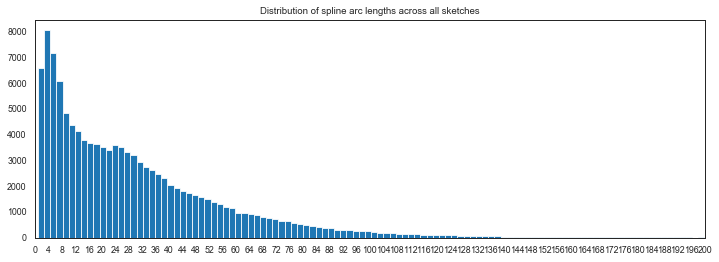

In [25]:
## get all spline lengths
flat_spline_lengths = flatten(svg_abs_spline_lengths)

## make figure
plt.figure(figsize=(12,4))
sns.set_context('paper')
plt.title('Distribution of spline arc lengths across all sketches')
plt.hist(flat_spline_lengths,200)
plt.xticks(np.linspace(0,200,51))
plt.xlim(0,200)

In [26]:
flat_spline_lengths_arr = np.array(flat_spline_lengths)
len(flat_spline_lengths_arr[flat_spline_lengths_arr>np.mean(flat_spline_lengths_arr)-np.std(flat_spline_lengths_arr)*3])

117934

### Identifying sketches with shift key error

In [82]:
## count up splines per sketch that are among the 20% shortest of splines, and we will call these "short splines"
short_spline_pct_threshold = 20
spline_length_threshold = np.percentile(flat_spline_lengths,short_spline_pct_threshold)
## spline_length_threshold = 6 #### hardcoded threshold

##We want to find out how many sketches have a large number of short splines to diagnose the shift-key error
num_short_splines=[]
for i,sketch in meta.iterrows():
    _num_short_splines=0
    for j in range(0,min(sketch['numSplines'],len(svg_abs_spline_lengths[i]))):
        if svg_abs_spline_lengths[i][j]<spline_length_threshold: 
            _num_short_splines+=1 
    num_short_splines.append(_num_short_splines)
        
## create copy of meta data frame where we add some extra info about the number of short splines        
ts_df = meta
ts_df['num_short_splines'] = num_short_splines

In [83]:
## define thresholds
retention_threshold = 95
num_short_spline_thresh = np.percentile(ts_df['num_short_splines'],retention_threshold)
num_all_splines_thresh = np.percentile(ts_df['numSplines'],retention_threshold)
print 'Our threshold for num_short_splines = {}, and our threshold for num_all_splines is {}'.\
        format(num_short_spline_thresh,num_all_splines_thresh)

## actually filter out the sketches with too many short splines (top 5%) AND too many splines overall (top 5%)
ts_df_2 = ts_df[(ts_df['num_short_splines']<num_short_spline_thresh) & (ts_df['numSplines']<num_all_splines_thresh)] 
ts_df_2 = ts_df_2.reset_index()

print 'After filtering, the number of sketches in our dataset = {}'.format(ts_df_2.shape[0])

Our threshold for num_short_splines = 21.0, and our threshold for num_all_splines is 92.1
After filtering, the number of sketches in our dataset = 1198


mean= 34.46577629382304
std= 15.898595137361244
max= 92


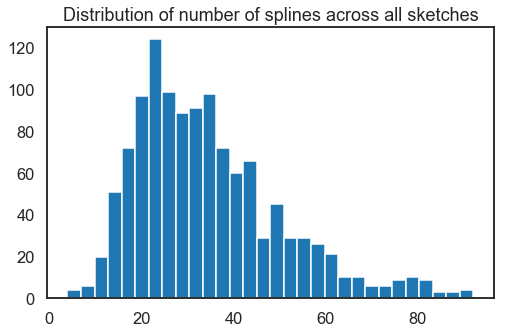

In [87]:
sns.set_context('talk')
plt.figure(figsize=(8,5))
plt.title('Distribution of number of splines across all sketches')
h = plt.hist(ts_df_2['numSplines'],30)

print "mean=", ts_df_2['numSplines'].mean()
print "std=", ts_df_2['numSplines'].std()
print "max=", ts_df_2['numSplines'].max()

In [90]:
## now re-assign the content of ts_df_2 back to meta, so we can upload this "troubleshot dataframe"
meta = ts_df_2

### upload stim dictionary to mongo (db = 'stimuli', collection='sketchpad_basic_recog')

In [91]:
## toggle whether we want to filter
filtered = True
    
## write out metadata to json file

## for example:
stimdict = meta.to_dict(orient='records')
stimdict
import json
with open('annotation_meta_{}.js'.format(category_flag), 'w') as fout:
     json.dump(stimdict, fout)

In [105]:
## load in the JSON that contains the svgData, object labels, and part labels
J = json.loads(open('annotation_meta_{}.js'.format(category_flag),mode='ru').read())
assert len(J)==len(meta)

In [106]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')

u'svg_annotation_sketchpad_basic_allcats'

In [108]:
print 'We have {} sketches in our dataset to upload.'.format(len(J)) 

We have 1198 sketches in our dataset to upload.


In [119]:
## actually add data now to the database 
reallyRun = True

## upload two versions of the stim dataset, a "dev mode" version and production version
dev_modes = [True,False]

if reallyRun:
    for dev_mode in dev_modes:
        ## define the dbname and collection name
        db = conn['stimuli']
        if dev_mode:
            coll = db['svg_annotation_sketchpad_basic_{}_dev'.format(category_flag)]
        else:
            coll = db['svg_annotation_sketchpad_basic_{}'.format(category_flag)]
        print 'Collection currently being uploaded is {}'.format(coll.name)
        for (i,j) in enumerate(J):
            if i%250==0:
                print ('%d of %d' % (i,len(J)))
            coll.insert_one(j)
            
print 'All done uploading!'            

Collection currently being uploaded is svg_annotation_sketchpad_basic_allcats_dev
0 of 1198
250 of 1198
500 of 1198
750 of 1198
1000 of 1198
Collection currently being uploaded is svg_annotation_sketchpad_basic_allcats
0 of 1198
250 of 1198
500 of 1198
750 of 1198
1000 of 1198


In [120]:
## How many sketches do we have in the database?
print 'We have {} sketches.'.format(coll.count())

## What kind of sketches do we have in the database?
print 'We have these kinds: {}'.format(str(coll.distinct('category')))

We have 1198 sketches.
We have these kinds: [u'chair', u'dog', u'bird', u'car']


### check how many sketches have been tagged in the collection how many times

In [121]:
cumulative = []
print 'There are: '
for i in np.arange(10):
    print '{} sketches that have been retrieved {} times from the database.'.format(coll.find({'games': {'$size': i}}).count(),i)
    cumulative.append(coll.find({'games': {'$size': i}}).count())
print 'While not guaranteed, sketches retrieved from the database are usually annotated, so this is a reasonable proxy for how many sketches have been annotated.'

There are: 
1198 sketches that have been retrieved 0 times from the database.
0 sketches that have been retrieved 1 times from the database.
0 sketches that have been retrieved 2 times from the database.
0 sketches that have been retrieved 3 times from the database.
0 sketches that have been retrieved 4 times from the database.
0 sketches that have been retrieved 5 times from the database.
0 sketches that have been retrieved 6 times from the database.
0 sketches that have been retrieved 7 times from the database.
0 sketches that have been retrieved 8 times from the database.
0 sketches that have been retrieved 9 times from the database.
While not guaranteed, sketches retrieved from the database are usually annotated, so this is a reasonable proxy for how many sketches have been annotated.
